# Coursework 1 : The three body problem

You should complete your coursework in this notebook and hand it in *via QMPlus* by 5pm on Friday of week 9 (24 November).

The broad goal of the project is to write code to model coplanar stellar systems (i.e., all the motion is in the x and y directions) with up to three stars.

## Your code must model the following 3 scenarios

1. A two body system made up of two stars with a mass ratio 1:2 undergoing multiple stable orbits (which may be elliptic). The stars obey Newton's law:

    $\vec{F}_{12} = - \frac{G m_1 ~ m_2 }{|r_{12}|^2} \frac{\vec{r}_{12}}{|\vec{r}_{12}|}$

    (You can work in units in which we set $G=1$ and the masses are order 1 numbers, but you can also choose to work in real units, as you prefer.)

2. A three body system made up of 3 stars of equal mass. Stars are assumed to be point like objects and so they cannot collide with each other (they simply pass through if at the same location). Model the stable solution discovered by Cris Moore and proved by Chenciner and Montgomery, described [here](https://arxiv.org/abs/math/0011268) and one in which they display chaotic behaviour, with one star being ejected from the system.

3. You now have a system of hypergiants. Hypergiants are the most massive stars, and so they cannot be treated as point like objects. Now if they get within some distance of each other, they should merge (*HINT: maybe we could say that they "add" themselves...*) into a single hypergiant with a combined mass of the two objects. Since momentum is conserved, we will also require that:

    $(m_1 + m_2)\vec{v}_{new} = m_1 \vec{v}_1 + m_2 \vec{v}_2$

    In this case, set up initial conditions so that you have 3 hypergiants initially, and a few orbits are obtained before a merger of two of the objects. The hypergiants should have 3 similar but different masses, e.g. a ratio of 0.8 : 1.0 : 1.2. You can choose the distance at which they merge, but it should be proportional to the masses of the two objects that are merging.

## Required components

To obtain full marks your solutions must include the following components:

1. Classes for stars, supergiants and stellar systems with multiple star components. Use of inheritance where possible and appropriate 

_(HINT: try to think ahead - what features of scenario 1 might you want to reuse in scenarios 2 and 3? You can save time coding by making it sufficiently general from the start.)_

2. Plots of the orbital trajectories of the stars over time

3. Phase diagrams for the position and velocities of the component stars.

4. Comparison of two explicit integration techniques - the first should be scipy's solve_ivp() and the second should be the midpoint method (or another Runge Kutta method of specified order). For the latter you should confirm the order of convergence of the solution is as expected.

_(HINT: you may want to investigate the rtol parameter for solve_ivp().)_

5. Documentation of the code appropriate for new users who have a basic familiarity with python and ODEs (your colleagues on this course, for example!), implemented in markdown around the code blocks.

6. Defensive programming techniques including asserts and tests of key functionality


## Marking scheme

   - 50% for working code that correctly implements all of the requested physical scenarios
   - 20% for use of defensive programming techniques - asserts and tests implemented to prevent user error and check functioning correctly, including a convergence test
   - 20% for readability of code, following the agreed naming conventions of the course, appropriate commenting
   - 10% for appropriate documentation of the code implemented in markdown format


In [4]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
g = 1
radius_to_mass = 0.03

In [38]:
class ExplicitIntegrator :

    """
    Contains explicit methods to integrate ODEs
    
    attributes: the function to calculate the gradient dydt, max_time, 
                N_time_steps, method
                
    methods: calculate_solution, plot_solution
    
    """
    integration_methods = ["Euler", "MidPoint", "RK4"]
    
    # constructor function
    def __init__(self, dydt, max_time=0, N_time_steps=0, method = "Euler"):
        
        self.dydt = dydt # Note that we are passing in a function, this is ok in python
        self.method = method
        assert self.method in self.integration_methods, 'chosen integration method not implemented'
        
        # Make these private - restrict getting and setting as below
        self._max_time = max_time
        self._N_time_steps = N_time_steps
        
        # Derived from the values above
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, max_time, N_time_steps+1)
        self._y_solution = np.zeros_like(self._t_solution)

    # Enables the user to get the t solution
    @property
    def y_solution(self):
        return self._y_solution

    # Enables the user to get the y solution
    @property
    def t_solution(self):
        return self._t_solution
    
    @property
    def max_time(self):
        return self._max_time

    @property
    def N_time_steps(self):
        return self._N_time_steps
    
    # Enables the user to reset the max time
    @max_time.setter
    def max_time(self, value):
        self._max_time = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros_like(self._t_solution)
        
    # Enables the user to reset the number of time steps
    @N_time_steps.setter
    def N_time_steps(self, value):
        self._N_time_steps = value
        self._delta_t = self.max_time / self.N_time_steps
        self._t_solution = np.linspace(0.0, self.max_time, self.N_time_steps+1)
        self._y_solution = np.zeros_like(self._t_solution)

    def calculate_solution(self, y0) :
        if (self.method == "Euler") :
            self.integrate_using_Euler(self.dydt, y0)
            return self._y_solution
        elif (self.method == "MidPoint") :
            self.integrate_using_midpoint(self.dydt, y0)
            return self._y_solution
        else :
            assert False, 'integration method not implemented'

    def integrate_using_Euler(self, dydt_function, y0) :
        self._y_solution = np.zeros((len(self._t_solution), len(y0)))
        
        for itime, time in enumerate(self.t_solution) :
            if itime == 0 :
                self._y_solution[itime] = np.array(y0)
            else :
                dydt_at_t = dydt_function(time, self._y_solution[itime-1])
                self._y_solution[itime] = (self._y_solution[itime-1] + 
                                          dydt_at_t * self._delta_t)
            
    def integrate_using_midpoint(self, dydt_function, y0) :
        self._y_solution = np.zeros((len(self._t_solution), len(y0)))
        
        for itime, time in enumerate(self.t_solution) :
            if itime == 0:
                self._y_solution[itime] = np.array(y0)
            else :
                y_at_t_over_2 = self._y_solution[itime-1] + (1/2) * self._delta_t * dydt_function(time, self._y_solution[itime-1])

                self._y_solution[itime] = self._y_solution[itime-1] +  self._delta_t * dydt_function(time + (1/2) * self._delta_t, y_at_t_over_2)
   

In [42]:
# Stellar systems
class Stellar_system():

    integration_methods = ["RK45", "MidPoint"]

    def __init__(self, max_time=50,  N_time_steps=250 , integration_method='RK45', name=''):
        # Time parameters
        self.max_time = max_time
        self.N_time_steps = N_time_steps

        # star variables
        self.list_of_stars = []
        self.masses = np.array([])
        self.radii = np.array([])

        # Collision variables
        self.hypergiants = False
        self.assimilated = np.array([])
        self.collision_coordinates = np.array([])
        
        # System variables
        self.name = name
        assert integration_method in self.integration_methods
        self.integration_method = integration_method
        self._is_defined = False
        self.g = g

    def add_star(self, star):
        # Update system variables
        self.list_of_stars.append(star)
        self.masses = np.append(self.masses, star.mass)
        self.radii = np.append(self.radii, star.radius)
        self.assimilated = np.append(self.assimilated, False)

        if star.radius != 0:
            self.hypergiants = True
            # If one hypergiant, all stars are hypergiants
            self.radii = self.masses * radius_to_mass
        if len(self.list_of_stars) > 1:
            self._is_defined = True

    def solve_odes(self, t, conditions):
        dydt = np.zeros_like(conditions)

        # Check for collisions
        if self.hypergiants:
            for index1, _ in enumerate(self.list_of_stars):
                for index2, _ in enumerate(self.list_of_stars):
                    if index1 != index2 and self.assimilated[index1] == 0 and self.assimilated[index2] == 0:
                        # Check if distance is less than the sum of the radii
                        if np.sqrt(np.linalg.norm(conditions[4*index1:4*index1 + 2] - conditions[4*index2:4*index2 + 2])) < self.radii[index1] + self.radii[index2]:
                            indexes = [index1, index2]
                            # Find the index of the smaller star
                            index_small = indexes[np.argmin(self.radii[indexes])]
                            # Find the index of the larger star
                            index_large = np.abs(index_small - 1)

                            # Calculate the new mass and radius of the larger star
                            new_mass = self.masses[index_small] + self.masses[index_large]
                            new_radius = new_mass * radius_to_mass
                            new_velocity = (self.masses[index_small] * conditions[4*index_small + 2:4*index_small + 4] + self.masses[index_large] * conditions[4*index_large + 2:4*index_large + 4]) / new_mass

                            # Make the smaller star mass, radius, velocity, and position 0
                            self.collision_coordinates = np.append(self.collision_coordinates, conditions[4*index_small:4*index_small + 2])
                            self.masses[index_small] = 0
                            self.radii[index_small] = 0
                            conditions[4*index_small:4*index_small + 4] = np.array([0, 0, 0, 0])
                            self.assimilated[index_small] = True

                            # Update the larger star mass, radius, velocity, and position
                            self.masses[index_large] = new_mass
                            self.radii[index_large] = new_radius
                            conditions[4*index_large:4*index_large + 4] = np.array([conditions[4*index_large + 0], conditions[4*index_large + 1], new_velocity[0], new_velocity[1]])

        for index, star in enumerate(self.list_of_stars):
            if self.assimilated[index]:
                conditions[4*index:4*index + 4] = np.array([0, 0, 0, 0])
                dydt[4*index:4*index + 4] = np.array([0, 0, 0, 0])
            elif sum(self.assimilated) == len(self.list_of_stars) - 1:
                dydt[4*index + 0] = conditions[4*index + 2]
                dydt[4*index + 1] = conditions[4*index + 3]
                dydt[4*index + 2] = 0
                dydt[4*index + 3] = 0
            else:
                dydt[4*index + 0] = conditions[4*index + 2]
                dydt[4*index + 1] = conditions[4*index + 3]
                dydt[4*index + 2] = - self.g * sum(self.masses[i] * (conditions[4*index + 0] - conditions[4*i + 0]) / 
                                                (np.linalg.norm(conditions[4*index:4*index + 2] - conditions[4*i:4*i + 2]) ** 3) for i in range(len(self.list_of_stars)) if i != index)
                dydt[4*index + 3] = - self.g * sum(self.masses[i] * (conditions[4*index + 1] - conditions[4*i + 1]) / 
                                                (np.linalg.norm(conditions[4*index:4*index + 2] - conditions[4*i:4*i + 2]) ** 3) for i in range(len(self.list_of_stars)) if i != index)

        return dydt

    def calculate_movement(self, method='RK45'):
        assert self._is_defined, "System is not defined, add at least two stars"
        initial_conditions = np.zeros(len(self.list_of_stars) * 4)    
        for index, star in enumerate(self.list_of_stars):
            initial_conditions[4*index + 0] = star.starting_position[0]
            initial_conditions[4*index + 1] = star.starting_position[1]
            initial_conditions[4*index + 2] = star.starting_velocity[0]
            initial_conditions[4*index + 3] = star.starting_velocity[1]

        t_solution = np.linspace(0.0, self.max_time, self.N_time_steps + 1)

        if method == 'RK45':
            solution = solve_ivp(self.solve_odes, [0, self.max_time], initial_conditions, t_eval=t_solution)
        if method == 'MidPoint':
            explicit_integrator_midpoint = ExplicitIntegrator(self.solve_odes, self.max_time, self.N_time_steps, method='MidPoint')
            solution = explicit_integrator_midpoint.calculate_solution(initial_conditions)

        return solution
    
    def plot_movement(self):
        solution = self.calculate_movement(method=self.integration_method)

        print(solution)

        if self.integration_method == 'RK45':
            if not self.hypergiants:
                centre_of_mass = np.array([sum(self.masses[i] * solution.y[4*i +j] for i, _ in enumerate(self.list_of_stars)) / np.sum(self.masses) for j in range(2)])

                if np.abs(centre_of_mass[0][0] - centre_of_mass[0][-1]) < 0.000001 and np.abs(centre_of_mass[1][0] - centre_of_mass[1][-1]) < 0.000001:
                    plt.scatter(centre_of_mass[0][0], centre_of_mass[1][0], label='Centre of mass', color='r')
                else:
                    plt.plot(centre_of_mass[0], centre_of_mass[1], label='Centre of mass', color='r')

            if len(self.collision_coordinates) > 0:
                plt.scatter(self.collision_coordinates[0], self.collision_coordinates[1], label='Collision', color='k')

            for index, star in enumerate(self.list_of_stars):
                stop = len(solution.y[0])
                for i in range(len(solution.y[0])):
                    if solution.y[4*index + 0][i] == 0 and solution.y[4*index + 1][i] == 0 and solution.y[4*index + 2][i] == 0 and solution.y[4*index + 3][i] == 0:
                        stop = i
                        break
                plt.plot(solution.y[4*index + 0][:stop], solution.y[4*index + 1][:stop], label=star.name)
            
        else:
            if not self.hypergiants:
                centre_of_mass = np.array([sum(self.masses[i] * solution[4*i +j] for i, _ in enumerate(self.list_of_stars)) / np.sum(self.masses) for j in range(2)])

                if np.abs(centre_of_mass[0][0] - centre_of_mass[0][-1]) < 0.000001 and np.abs(centre_of_mass[1][0] - centre_of_mass[1][-1]) < 0.000001:
                    plt.scatter(centre_of_mass[0][0], centre_of_mass[1][0], label='Centre of mass', color='r')
                else:
                    plt.plot(centre_of_mass[0], centre_of_mass[1], label='Centre of mass', color='r')

            if len(self.collision_coordinates) > 0:
                plt.scatter(self.collision_coordinates[0], self.collision_coordinates[1], label='Collision', color='k')

            for index, star in enumerate(self.list_of_stars):
                stop = len(solution[0])
                for i in range(len(solution[0])):
                    if solution[4*index + 0][i] == 0 and solution[4*index + 1][i] == 0 and solution[4*index + 2][i] == 0 and solution[4*index + 3][i] == 0:
                        stop = i
                        break
                plt.plot(solution[4*index + 0][:stop], solution[4*index + 1][:stop], label=star.name)
           

        plt.legend()

In [43]:
# Class: star
class star():

    def __init__(self, name='', mass=1, giant=False, starting_position=np.array([0,0]), starting_velocity=np.array([0,0])):
        self.name = name

        # star variables
        self.mass = mass
        if giant:
            self.radius = self.mass * radius_to_mass
        else:
            self.radius = 0
        self.starting_position = starting_position
        self.starting_velocity = starting_velocity

### Examples

[[ 0.00000000e+00  0.00000000e+00 -5.00000000e-01 ...  0.00000000e+00
   2.50000000e-01 -2.50000000e-01]
 [-4.99790000e-04  5.00000000e-04 -4.99580315e-01 ... -2.50000000e-04
   2.49790157e-01 -2.49999921e-01]
 [-9.99160630e-04  9.99999686e-04 -4.99161259e-01 ... -4.99999843e-04
   2.49580629e-01 -2.49999686e-01]
 ...
 [-9.08873487e-01  4.76139754e+00  3.16500766e-02 ... -2.38069877e+00
  -1.58250383e-02 -5.79593875e-02]
 [-9.08841835e-01  4.76151345e+00  3.16524079e-02 ... -2.38075673e+00
  -1.58262039e-02 -5.79558648e-02]
 [-9.08810182e-01  4.76162936e+00  3.16547389e-02 ... -2.38081468e+00
  -1.58273695e-02 -5.79523423e-02]]


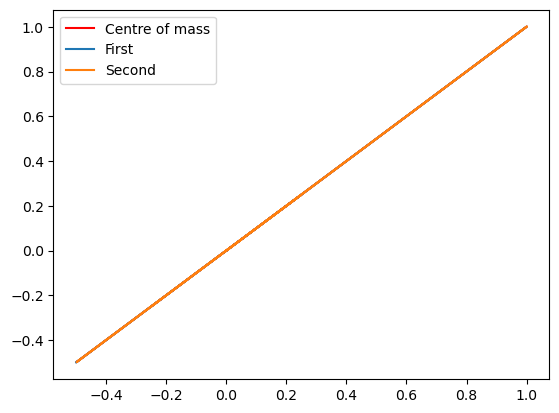

In [44]:
# 2-body problem [0,0,0,0.5] and [1,0,0,-0.5] work well

first_star = star(name='First', mass=0.21, starting_position=np.array([0,0]), starting_velocity=np.array([-0.5,0.5]))
second_star = star(name='Second', mass=0.42, starting_position=np.array([1,0]), starting_velocity=np.array([0.25,-0.25]))

my_stellar_system = Stellar_system(max_time=100, N_time_steps=100000, integration_method='MidPoint', name='Solar system')

my_stellar_system.add_star(first_star)
my_stellar_system.add_star(second_star)

am = my_stellar_system.plot_movement()
solution_2bp = my_stellar_system.calculate_movement()

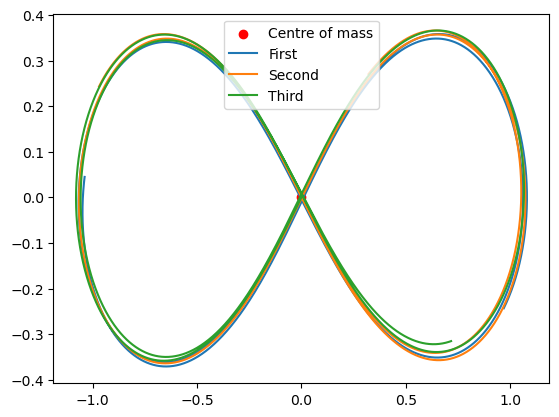

In [9]:
# 3-body problem

first_star = star(name='First', mass=1, starting_position=np.array([0.97000436,-0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
second_star = star(name='Second', mass=1, starting_position=np.array([-0.97000436,0.24308753]), starting_velocity=np.array([0.93240737/2,0.86473146/2]))
third_star = star(name='Third', mass=1, starting_position=np.array([0,0]), starting_velocity=np.array([-0.93240737,-0.86473146]))

my_stellar_system = Stellar_system(max_time=10, N_time_steps=10000, name='Solar system')

my_stellar_system.add_star(first_star)
my_stellar_system.add_star(second_star)
my_stellar_system.add_star(third_star)

my_stellar_system.plot_movement()

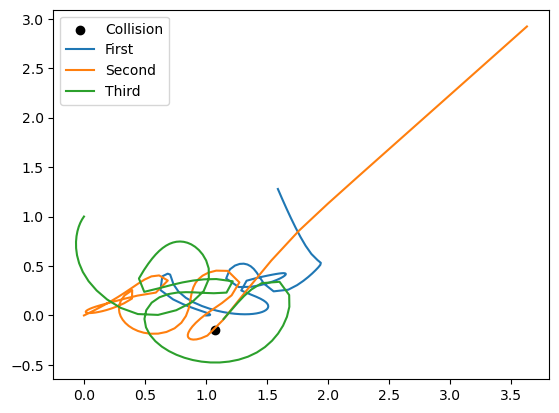

In [19]:
# 3-body problem - hypergiants

first_star = star(name='First', mass=1.2, giant=True, starting_position=np.array([1, 0]), starting_velocity=np.array([0.3,0]))
second_star = star(name='Second', mass=1, giant=True, starting_position=np.array([0,0]), starting_velocity=np.array([0.5,0.3]))
third_star = star(name='Third', mass=0.8, giant=True, starting_position=np.array([0,1]), starting_velocity=np.array([-0.3,-0.5]))

my_stellar_system = Stellar_system(max_time=5.5, N_time_steps=100, integration_method='RK45', name='Solar system')

my_stellar_system.add_star(first_star)
my_stellar_system.add_star(second_star)
my_stellar_system.add_star(third_star)

my_stellar_system.plot_movement()